# Authorship of the Federalist Papers

The _Federalist Papers_ were a set of 85 essays published between 1787 and 1788 to promote the ratification of the United States Constitution. They were originally published under the pseudonym "Publius". Although the identity of the authors was a closely guarded secret at the time, most of the papers have since been conclusively attributed to one of Hamilton, Jay, or Madison. The known authorships can be found in `https://dlsun.github.io/pods/data/federalist/authorship.csv`.

For 15 of the papers, however, the authorships remain disputed. (These papers can be identified from the `authorship.csv` file because the "Author" field is blank.) In this analysis, you will use the papers with known authorship to predict the authorships of the disputed papers. The text of each paper is available at `https://dlsun.github.io/pods/data/federalist/x.txt`, where `x` is the number of the paper (i.e., a number from 1 to 85). The name of the file indicates the number of the paper.

In [30]:
import pandas as pd
import requests
from collections import Counter
df_author = pd.read_csv("https://dlsun.github.io/pods/data/federalist/authorship.csv")
fed_docs = pd.Series()
for i in df_author["Paper"]:
  file = str(i)+".txt"
  response = requests.get("https://dlsun.github.io/pods/data/federalist/"+ file, "r")
  fed_docs[file[:-4]] = response.text
df_author["Author"].fillna("Unknown", inplace = True)
df_unknown = df_author[df_author["Author"]=="Unknown"]
df_unknown["Paper"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


17    18
18    19
19    20
48    49
49    50
50    51
51    52
52    53
53    54
54    55
55    56
56    57
57    58
61    62
62    63
Name: Paper, dtype: int64

## Question 1

When analyzing an author's style, common words like "the" and "on" are actually more useful than rare words like "hostilities". That is because rare words typically signify context. Context is useful if you are trying to find documents about similar topics, but not so useful if you are trying to identify an author's style because different authors can write about the same topic. For example, both Dr. Seuss and Charles Dickens used rare words like "chimney" and "stockings" in _How the Grinch Stole Christmas_ and _A Christmas Carol_, respectively. But they used common words very differently: Dickens used the word "upon" over 100 times, while Dr. Seuss did not use "upon" even once.

Read in the Federalist Papers. Convert each one into a vector of term frequencies. In order to restrict to common words, include only the top 50 words across the corpus. (Because we are restricting to the most common words already, there is no reason to reweight them using TF-IDF.)

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
vec.fit(fed_docs) # This determines the vocabulary.
tf_sparse = vec.transform(fed_docs)

all_sums = tf_sparse.sum(axis=0) 
frequencies = [(word, all_sums[0, idx]) for word, idx in vec.vocabulary_.items()]
frequencies = sorted(frequencies, key = lambda x: x[1], reverse=True)
frequencies[:50]


[('the', 17767),
 ('of', 11824),
 ('to', 7074),
 ('and', 5099),
 ('in', 4456),
 ('be', 3825),
 ('that', 2792),
 ('it', 2550),
 ('is', 2194),
 ('which', 2068),
 ('by', 1741),
 ('as', 1721),
 ('this', 1410),
 ('would', 1273),
 ('have', 1262),
 ('will', 1255),
 ('for', 1237),
 ('or', 1233),
 ('not', 1215),
 ('their', 1098),
 ('with', 1053),
 ('from', 1043),
 ('are', 1032),
 ('on', 952),
 ('they', 928),
 ('an', 927),
 ('states', 851),
 ('government', 829),
 ('may', 816),
 ('been', 798),
 ('state', 787),
 ('all', 731),
 ('but', 697),
 ('its', 651),
 ('other', 646),
 ('people', 612),
 ('has', 603),
 ('power', 603),
 ('more', 579),
 ('at', 568),
 ('if', 563),
 ('than', 550),
 ('them', 548),
 ('one', 547),
 ('any', 545),
 ('no', 506),
 ('those', 481),
 ('can', 465),
 ('constitution', 463),
 ('we', 461)]

Of our top 50, 'the' is the most commonly used word and 'we' is the least commonly used.

How I found out the method of getting individual sums for each column in my term frequency dataframe(how I got my frequencies array):
https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d

## Question 2
Make a visualization that summarizes the most common words used by Hamilton, Madison, and Jay.

(<matplotlib.axes._subplots.AxesSubplot at 0x7f5fb9f05e10>,
      freq        word
 0   17767         the
 1   11824          of
 2    7074          to
 3    5099         and
 4    4456          in
 5    3825          be
 6    2792        that
 7    2550          it
 8    2194          is
 9    2068       which
 10   1741          by
 11   1721          as
 12   1410        this
 13   1273       would
 14   1262        have
 15   1255        will
 16   1237         for
 17   1233          or
 18   1215         not
 19   1098       their
 20   1053        with
 21   1043        from
 22   1032         are
 23    952          on
 24    928        they
 25    927          an
 26    851      states
 27    829  government
 28    816         may
 29    798        been)

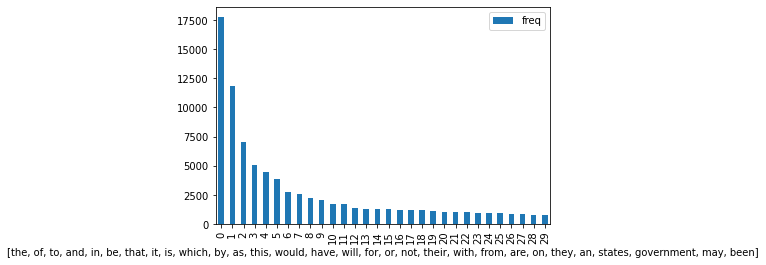

In [32]:
rows = []
for i in range(30):
  row = {}
  row["freq"] = frequencies[i][1]
  row["word"] = frequencies[i][0]
  rows.append(row)
df_freq = pd.DataFrame(rows)
df_freq.plot.bar(xlabel = df_freq["word"]), df_freq

As a general trend, it is the filler words such as 'the', 'of', 'to', 'and', etc. that are the most frequent, followed by words such as 'would', 'their', 'which' etc. The frequencies, when sorted, decrease exponentially, eventually leveling out to where most words tend to stay in a similar area after the most top 10 most common words.

## Question 3

For each of the documents with disputed authorships, find the 5 most similar documents with _known_ authorships, using cosine distance on the term frequencies. Use the authors of these 5 most similar documents to predict the author of each disputed document. (For example, if 3 of the 5 closest documents were written by Hamilton, 1 by Madison, and 1 by Jay, then we would predict that the disputed document was written by Hamilton.)

In [33]:
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
import numpy as np

for unk in df_unknown["Paper"]:
  tmp_list = []
  counter = 0
  idx = 0
  simlist = cosine_similarity(tf_sparse)[unk-1]
  #for sim in range(len(simlist)):

  tmp = sorted(simlist, reverse=True)
  while(counter<5):
    sim_idx = np.where(simlist == tmp[idx])
    auth = df_author.iloc[sim_idx[0]]["Author"]
    if auth.item() != "Unknown":
      tmp_list.append(auth.item())
      counter+=1
    idx+=1
  elem = max(set(tmp_list), key=tmp_list.count)
    
  print(unk, elem)

18 Madison
19 Hamilton
20 Madison
49 Madison
50 Madison
51 Madison
52 Madison
53 Madison
54 Hamilton
55 Hamilton
56 Hamilton
57 Madison
58 Madison
62 Hamilton
63 Madison


Documents 18, 20, 49-53, 57, 58, and 63: Madison is the author

Documents 19, 54-56, 62: Hamilton

None of the documents were predicted to have been authored by Jay.

## Submission Instructions

- Copy this notebook to your own Drive, if you have not already.
- Restart this notebook and run the cells from beginning to end. 
  - Go to Runtime > Restart and Run All.
- Rename this notebook by clicking on "DATA 301 Lab 5 - YOUR NAMES HERE" at the very top of this page. Replace "YOUR NAMES HERE" with the first and last names of you (and your partners, for Phase 2).
- Get the link to your notebook:
  - Click on "Share" at the top-right. 
  - Change the settings to "Anyone with the link can view". 
  - Copy the sharing link into Canvas.